In [1]:
import json
import random

from tqdm import tqdm

import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from colorama import Fore
from transformers import BertTokenizer

from Sample import Sample, create_examples
from preprocessing import create_inputs_targets

In [2]:
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [3]:
slow_tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [4]:
slow_tokenizer.save_pretrained("slow_token")

('slow_token\\tokenizer_config.json',
 'slow_token\\special_tokens_map.json',
 'slow_token\\vocab.txt',
 'slow_token\\added_tokens.json')

In [5]:
from tokenizers import BertWordPieceTokenizer

In [6]:
tokenizer = BertWordPieceTokenizer("slow_token/vocab.txt", lowercase=True)

In [7]:
tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [8]:
with open("../AAAI-21-SDU-shared-task-2-AD/dataset/diction.json", "r") as f:
    diction = json.load(f)
with open("pos_data/train_pos_data.json", "r", encoding="UTF-8") as f:
    pos_train = json.load(f)
    
with open("neg_data/train_neg_data.json", "r", encoding="UTF-8") as f:
    neg_train = json.load(f)

In [9]:
print(len(pos_train))

50034


In [10]:
print(len(neg_train))

65498


Text(0, 0.5, 'Number of samples')

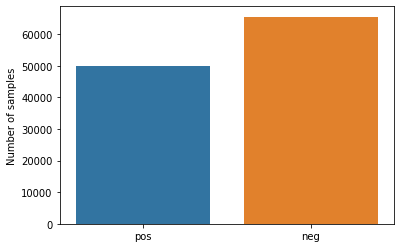

In [11]:
fig = plt.figure()
x = ["pos", "neg"]
y = [len(pos_train), len(neg_train)]

sns.barplot(x=x, y=y)
plt.ylabel("Number of samples")

In [12]:
examples_pos = create_examples(pos_train, "pos", "Create pos training points", tokenizer)

Create pos training points: 100%|██████████| 50034/50034 [00:23<00:00, 2128.25it/s]


In [13]:
examples_neg = create_examples(neg_train, "neg", "Create neg training points", tokenizer)

Create neg training points: 100%|██████████| 65498/65498 [00:37<00:00, 1757.04it/s]


In [14]:
assert len(neg_train) == len(examples_neg)

In [15]:
assert len(pos_train) == len(examples_pos)

In [16]:
examples_pos.extend(examples_neg)

In [17]:
assert len(examples_pos) == len(pos_train)+len(neg_train)

In [18]:
X, Y = create_inputs_targets(examples_pos)

In [19]:
X[0].shape

(115175, 384)

In [20]:
Y[2].shape

(115175,)

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [26]:
train_data = TensorDataset(torch.tensor(X[0], dtype=torch.int64),  #input_ids
                            torch.tensor(X[1], dtype=torch.int64), #input_type_ids
                            torch.tensor(X[2], dtype=torch.float), #attention_mask
                            torch.tensor(Y[0], dtype=torch.int64), #start_token_acr
                            torch.tensor(Y[1], dtype=torch.int64), #end_token_acr
                            torch.tensor(Y[2], dtype=torch.int64)) #label
    

In [27]:
len(train_data)

115175

In [28]:
train_sampler = RandomSampler(train_data)

In [29]:
train_data_loader = DataLoader(train_data, sampler=train_sampler, batch_size=16)

In [30]:
from transformers import BertPreTrainedModel

In [31]:
from transformers import BertModel

In [32]:
import torch
import torch.nn as nn

class AcrBertModel(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.init_weights()

        self.bert = BertModel(config, add_pooling_layer=False)

        self.dropout_1 = nn.Dropout(p=0.2)
        self.dense_1  = nn.Linear(768*2, 128)
        self.relu = nn.ReLU()
        self.dropout_2 = nn.Dropout(p=0.1)
        self.dense_2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

        self.init_weights()
    
    def forward(
        self, 
        input_ids, token_type_ids, attention_mask, start_token_idx, end_token_idx):

        features_extract = self.bert(input_ids = input_ids, 
                                    attention_mask = attention_mask, 
                                    token_type_ids = token_type_ids)[0]

        features_cls = features_extract[:, 0, :].unsqueeze(1)
        if start_token_idx is not None and end_token_idx is not None:
            list_mean_feature_acr = []
            for idx in range(start_token_idx.shape[0]):
                feature_acr = features_extract[idx, start_token_idx[idx]:end_token_idx[idx], :].unsqueeze(0)
                mean_feature_acr = torch.mean(feature_acr, 1, True)
                list_mean_feature_acr.append(mean_feature_acr)
        features_crc = torch.cat(list_mean_feature_acr, dim=0)

        features = torch.cat([features_cls, features_crc], dim=2)

        features = self.dropout_1(features)
        features = self.dense_1(features)
        features = self.relu(features)
        features = self.dropout_2(features)
        features = self.dense_2(features)
        output = self.sigmoid(features)

        return output

In [130]:
from transformers import BertModel

In [89]:
model = AcrBertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing AcrBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing AcrBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AcrBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AcrBertModel were not initialized from the model checkpoint at bert-base-unc

In [90]:
model

AcrBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [91]:
# model = BertForQuestionAnswering.from_pretrained("bert-large-uncased").to(device=gpu)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [94]:
optimizer = torch.optim.Adam(lr=1e-5, betas=(0.9, 0.98), eps=1e-9, params=optimizer_grouped_parameters)

In [95]:
import json
import os
import re
import sys

import requests
import string
import numpy as np
from colorama import Fore
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm

In [96]:
loss_fn = nn.CrossEntropyLoss()

In [99]:
for epoch in range(1, 10 + 1):
    # ============================================ TRAINING ============================================================
    print("Training epoch ", str(epoch))
    training_pbar = tqdm(total=len(train_data),
                         position=0, leave=True,
                         file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET))
    model.train()
    tr_loss = 0
    nb_tr_steps = 0
    for step, batch in enumerate(train_data_loader):
        batch = tuple(t for t in batch)
        input_word_ids, input_type_ids, input_mask, start_token_idx, end_token_idx, label= batch
        optimizer.zero_grad()
        output = model(input_ids=input_word_ids,
                    token_type_ids=input_type_ids,
                    attention_mask=input_mask,
                    start_token_idx=start_token_idx,
                    end_token_idx=end_token_idx)
        # print(loss)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        training_pbar.update(input_word_ids.size(0))
    training_pbar.close()
    torch.save(model.state_dict(), "./weights_" + str(epoch) + ".pth")
    # ============================================ VALIDATION ==========================================================

Training epoch  1
  0%|          | 0/115175 [00:00<?, ?it/s]

KeyboardInterrupt: 